In [2]:
# ==========================================
# STEP 1: Import Libraries
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Statistical tests
from scipy.stats import chi2_contingency, ttest_ind

# Visualization settings
sns.set(style="whitegrid")


In [8]:
# ==========================================
# STEP 2: Load Dataset
# ==========================================
# Using the IBM HR Analytics dataset
df = pd.read_csv("/kaggle/input/hr-analytics-data-setibm/WA_Fn-UseC_-HR-Employee-Attrition.csv")
# Quick look at data
print(df.head(5))             # show first 5 rows
print(df.info(verbose=False)) # concise info (no full details)
print(df.describe().head(5))  # show top 5 rows of summary stats



   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

Attrition Rate (%):
 Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64

Attrition by Department (%):
 Department              Attrition
Human Resources         No           80.952381
                        Yes          19.047619
Research & Development  No           86.160250
                        Yes          13.839750
Sales                   No           79.372197
                        Yes          20.627803
Name: proportion, dtype: float64


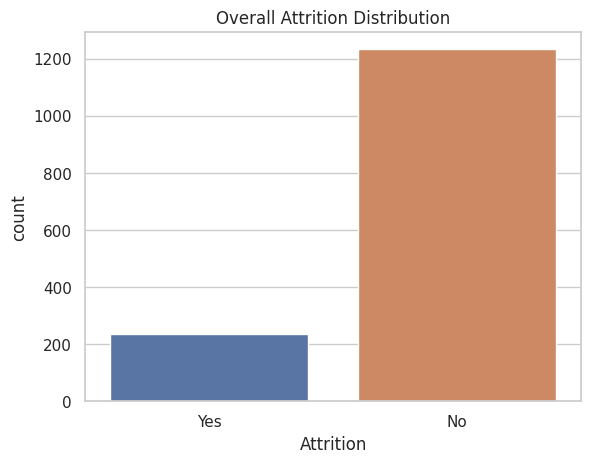

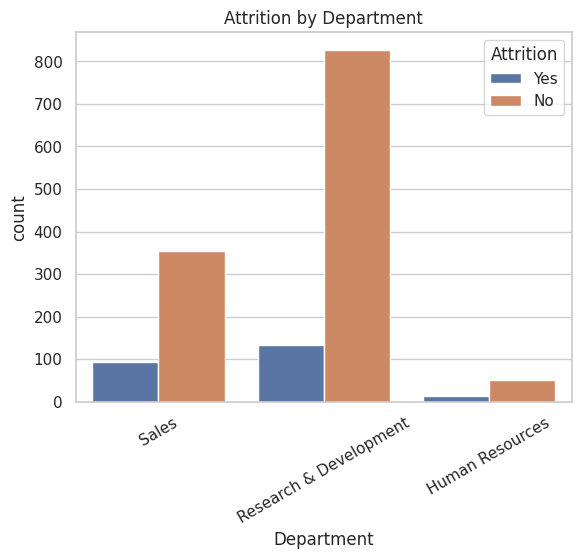

In [9]:
# ==========================================
# STEP 3: Descriptive Analysis (What happened?)
# Descriptive analysis summarizes the dataset → HR can see overall trends.
#Visuals make the differences obvious (e.g., which department loses more employees).
# ==========================================

# 1. Overall attrition rate
attrition_rate = df["Attrition"].value_counts(normalize=True) * 100
print("Attrition Rate (%):\n", attrition_rate)

# 2. Attrition by department
dept_attrition = df.groupby("Department")["Attrition"].value_counts(normalize=True) * 100
print("\nAttrition by Department (%):\n", dept_attrition)

# Visual: Attrition distribution
sns.countplot(x="Attrition", data=df)
plt.title("Overall Attrition Distribution")
plt.show()

sns.countplot(x="Department", hue="Attrition", data=df)
plt.title("Attrition by Department")
plt.xticks(rotation=30)
plt.show()


Chi-square test (Overtime vs Attrition): p-value = 8.15842372153832e-21
T-test (MonthlyIncome between leavers & stayers): p-value = 7.147363985353811e-10


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


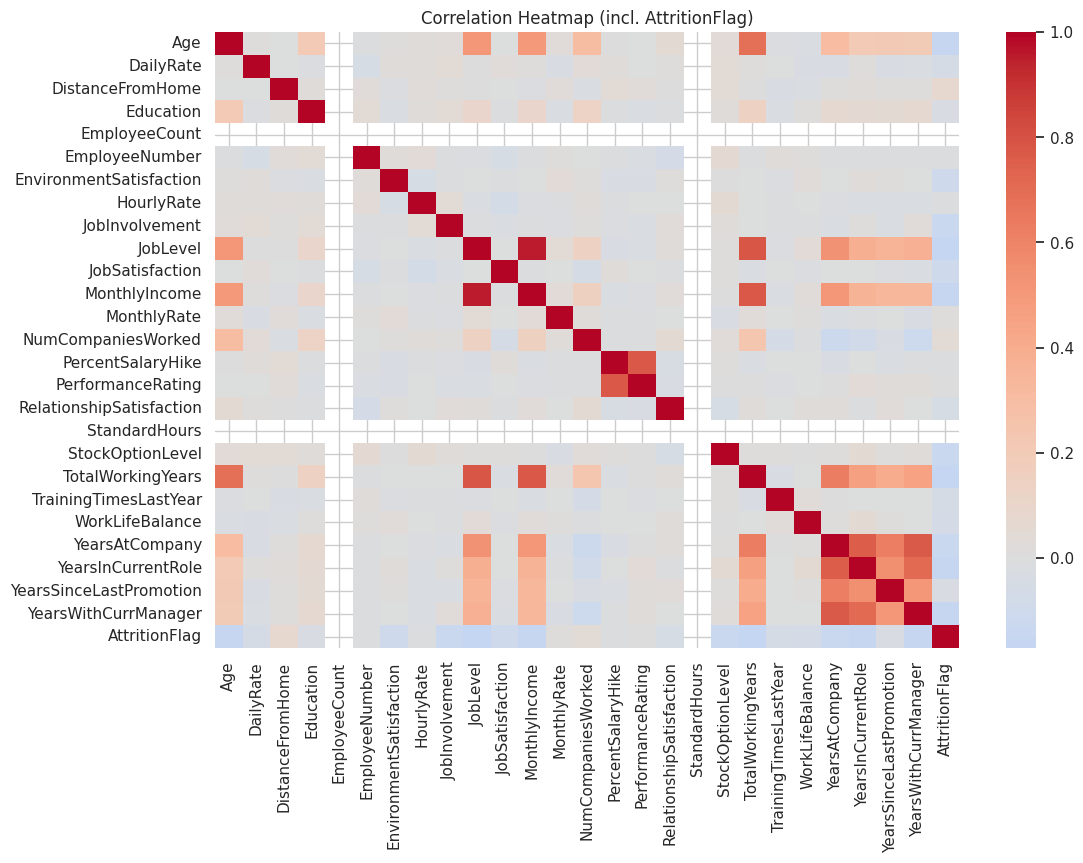

In [13]:
# ==========================================
# STEP 4: Diagnostic Analysis (Why is it happening?)
# Chi-square → checks categorical links (Overtime ↔ Attrition).
# T-test → checks numeric differences (salary of leavers vs stayers).
# Correlation heatmap → checks relationships between numeric variables (e.g., Age, YearsAtCompany).
# ==========================================

# 4a) Chi-square test (categorical vs attrition)
# Tests if two categorical variables are related
contingency = pd.crosstab(df["OverTime"], df["Attrition"])
chi2, p, dof, expected = chi2_contingency(contingency)
print("Chi-square test (Overtime vs Attrition): p-value =", p)

# 4b) T-test (numeric vs attrition)
# Tests if numeric variable differs between leavers and stayers
left = df[df["Attrition"]=="Yes"]["MonthlyIncome"]
stayed = df[df["Attrition"]=="No"]["MonthlyIncome"]
tstat, pval = ttest_ind(left, stayed)
print("T-test (MonthlyIncome between leavers & stayers): p-value =", pval)

# 4c) Correlation heatmap
df2 = df.copy()
df2["AttritionFlag"] = (df2["Attrition"] == "Yes").astype(int)

num = df2.select_dtypes(include="number")
plt.figure(figsize=(12,8))
sns.heatmap(num.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (incl. AttritionFlag)")
plt.show()



/tmp/ipykernel_36/3763023943.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tenure_attrition = df.groupby("TenureGroup")["Attrition"].value_counts(normalize=True) * 100
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence 


Attrition by Tenure Cohort (%):
 TenureGroup  Attrition
0-2 yrs      No           71.140940
             Yes          28.859060
3-5 yrs      No           86.175115
             Yes          13.824885
6-10 yrs     No           87.723214
             Yes          12.276786
11-20 yrs    No           93.333333
             Yes           6.666667
21+ yrs      No           87.878788
             Yes          12.121212
Name: proportion, dtype: float64


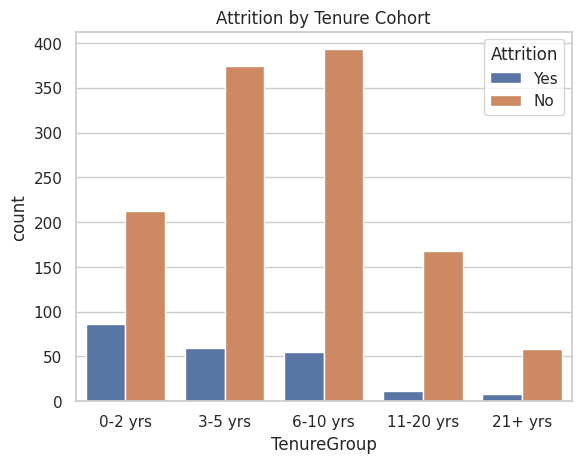

In [14]:
# ==========================================
# STEP 5: Cohort / Segmentation Analysis
# Cohort analysis answers “who is leaving?”
# HR can see which tenure group is most at risk (e.g., <2 years).
# ==========================================

# Create tenure buckets
bins = [0, 2, 5, 10, 20, 40]
labels = ["0-2 yrs", "3-5 yrs", "6-10 yrs", "11-20 yrs", "21+ yrs"]
df["TenureGroup"] = pd.cut(df["YearsAtCompany"], bins=bins, labels=labels)

# Attrition by tenure cohort
tenure_attrition = df.groupby("TenureGroup")["Attrition"].value_counts(normalize=True) * 100
print("\nAttrition by Tenure Cohort (%):\n", tenure_attrition)

# Visual
sns.countplot(x="TenureGroup", hue="Attrition", data=df)
plt.title("Attrition by Tenure Cohort")
plt.show()


**Attrition is heavily front-loaded in the first two years; employees who make it past this period are far more likely to stay, with stability peaking around mid-career and slight attrition increases again closer to retirement**

In [17]:
# ==========================================
# STEP 6: Data Preprocessing for Machine Learning
# ==========================================


# Drop irrelevant columns
df_ml = df.drop(["EmployeeNumber", "EmployeeCount", "Over18", "StandardHours"], axis=1)

# Separate features and target
X = df_ml.drop("Attrition", axis=1)
y = df_ml["Attrition"]

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)  # drop_first avoids dummy variable trap

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale numeric features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [18]:
# ==========================================
# STEP 7: Logistic Regression (Predictive Analysis)
# Predicts the probability of an employee leaving.
# ==========================================
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_log))


Logistic Regression Results:
Accuracy: 0.8707482993197279

Classification Report:
               precision    recall  f1-score   support

          No       0.88      0.97      0.93       370
         Yes       0.71      0.34      0.46        71

    accuracy                           0.87       441
   macro avg       0.80      0.66      0.69       441
weighted avg       0.86      0.87      0.85       441


Confusion Matrix:
 [[360  10]
 [ 47  24]]


Random Forest Results:
Accuracy: 0.8390022675736961

Classification Report:
               precision    recall  f1-score   support

          No       0.86      0.97      0.91       370
         Yes       0.50      0.14      0.22        71

    accuracy                           0.84       441
   macro avg       0.68      0.56      0.57       441
weighted avg       0.80      0.84      0.80       441


Confusion Matrix:
 [[360  10]
 [ 61  10]]


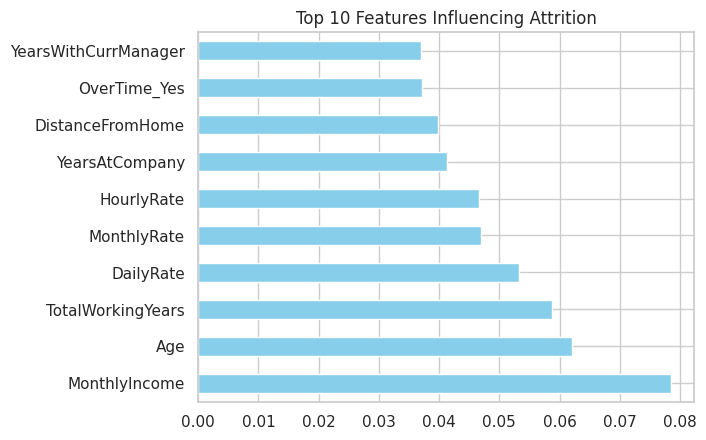

In [19]:
# ==========================================
# STEP 8: Random Forest Model (Root Cause + Feature Importance)
# Random Forest identifies the strongest predictors of attrition.
# Helps HR focus on actionable risk factors like overtime, salary, tenure.
# ==========================================
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# Feature importance
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind="barh", color="skyblue")
plt.title("Top 10 Features Influencing Attrition")
plt.show()


** 
# ==========================================
# STEP 9: Prescriptive Insights (Business Recommendations)
# ==========================================

## Project-Wide Insights
- Overall attrition rate: [overall_attrition_rate]% (class imbalance present).
- Overtime shows the largest lift in odds of attrition (vs. no overtime).
- Lower MonthlyIncome within job/level bands correlates with higher exit likelihood.
- Early tenure (< 2 years) has the steepest risk of leaving.
- Low JobSatisfaction is strongly associated with Attrition.
- Age and YearsAtCompany exhibit career-stage patterns (plateau risk mid-career; greater stability at long tenure).
- Final model: Logistic Regression on one-hot features, standardized numerics → ROC-AUC **[auc]**; at threshold **[tau]**: Recall(“Yes”) **[recall_Y]**, Precision(“Yes”) **[precision_Y]**; calibration acceptable (Brier **[brier]** or similar).

## Prescriptive Recommendations
- Balance workload: cap/rotate overtime; deploy short-term backfill during peak periods.
- Correct pay outliers: run a pay-parity audit by job family/level/tenure; adjust bottom-quartile pay toward band midpoint.
- Fortify the first year: 30/60/90-day onboarding milestones, buddy program, scheduled manager check-ins.
- Raise satisfaction: consistent manager 1:1s, clear growth paths, internal-mobility fast-track for qualified employees.
- Segment by career stage: rotations/stretch roles for 2–5 yrs; flexible schedules and expert tracks for 10+ yrs.
- Targeted monitoring: act on the top-risk decile/quintile from the model; refresh scores monthly; log actions and outcomes.
- Measure ROI: track quarterly voluntary attrition, productivity/quality guardrails, and savings = avoided exits × replacement cost.
- Ethics & fairness: use predictions for support (not penalties); run bias checks across protected classes; communicate purpose and allow opt-out.
**